## LSTM Implementation

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
model = nn.LSTMCell(10,20)

In [3]:
print(model.weight_hh.shape)
print(model.weight_ih.shape)

torch.Size([80, 20])
torch.Size([80, 10])


### LSTM Cell
https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html

In [4]:
from torch import Tensor
import math

In [200]:
class LSTMCell(nn.Module):
    
    def __init__(self,input_size:int ,hidden_size:int ,bias = True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        # When a tensor is wrapped with torch.nn.Parameter,
        # it is automatically registered as part of the model's parameters,
        
        self.wf = nn.Parameter(torch.randn(hidden_size,hidden_size))
        self.wi = nn.Parameter(torch.randn(hidden_size,hidden_size))
        self.wo = nn.Parameter(torch.randn(hidden_size,hidden_size))
        self.wc = nn.Parameter(torch.randn(hidden_size,hidden_size))
        
        self.uf = nn.Parameter(torch.randn(hidden_size,input_size))
        self.ui = nn.Parameter(torch.randn(hidden_size,input_size))
        self.uo = nn.Parameter(torch.randn(hidden_size,input_size))
        self.uc = nn.Parameter(torch.randn(hidden_size,input_size))
        
        if(bias):
            self.bf = nn.Parameter(torch.randn(hidden_size))
            self.bi = nn.Parameter(torch.randn(hidden_size))
            self.bo = nn.Parameter(torch.randn(hidden_size))
            self.bc = nn.Parameter(torch.randn(hidden_size))
    
        
        self.init_weights()
    
    
        
    # every weights and biases are taken from normal distribution from -rootk to rootk
    # where k = 1/hidden_size for convergence
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-stdv, stdv)
    
    
    def sigmoid(self,z):
        """sigmoid function squashes value 0 to 1"""
        return 1/(1+torch.exp(-z))
        
    def tanh(self,z):
        """tanh function squashes value -1 to 1"""
        a = torch.exp(z)
        b = torch.exp(-z)
        
        return (a - b) / (a + b)
    
    
            
            
    def forward(self,x:Tensor, prev_state : tuple[Tensor,Tensor] = None) -> tuple[Tensor,Tensor]:
        
        """x is input (Tensor) of shape (batch,input) or just input
            prev_state => ht-1 , ct-1
            
            output : 
                ht,ct both of shape (batch_size , hidden_size)
        """
        batch_size = x.size(0)
        
        if(x.dim() not in (1,2)):
            raise ValueError(f"Input is of shape {x.shape} . It should be 1D or 2D")
        
        if prev_state is None :
            
            ht_1 = torch.zeros(batch_size, self.hidden_size).to(x.device)
            ct_1 = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        ht_1 , ct_1 = prev_state
    
        # Forget gate , input and output
        f_linear = ht_1 @ self.wf + x @ self.uf.t()
        i_linear = ht_1 @ self.wi + x @ self.ui.t()
        o_linear = ht_1 @ self.wo + x @ self.uo.t()
                
            
        if(self.bias):
            f_linear += self.bf
            i_linear += self.bi
            o_linear += self.bo
        
        
        ft = self.sigmoid(f_linear)
        it = self.sigmoid(i_linear)
        ot = self.sigmoid(o_linear)
        
        if(self.bias):
            ctilda_t = self.tanh(ht_1 @ self.wc + x @ self.uc.t() + self.bc)
        
        ct = ft * ct_1 + ( it * ctilda_t)
        ht = ot * self.tanh(ct)
        
        return ht,ct

## LSTM 

TODO:- add num_layers in input

In [162]:
from torch import Tensor

In [201]:
class LSTM(nn.Module):
    
    def __init__(self,input_size,hidden_size,bias=True):
        
        super().__init__()
        
#         self.num_layers = num_layers

        self.hidden_size = hidden_size
        self.bias = bias
        
        self.lstmcell = LSTMCell(input_size=input_size,
                                hidden_size=hidden_size,
                                bias=bias)
            
            
    def forward(self,x:Tensor,initial_state : tuple[Tensor,Tensor] = None):
        
        """
         x ==> (batch_size X seq_len X input_size(features))
         initial_state ==> h0,c0 of shape (batch_size X hidden_size)
        """
        
        
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        output_seq = [] # to store every output h of cell
        
        
        if initial_state is None:
            h_prev = torch.zeros(batch_size, self.hidden_size).to(x.device)
            c_prev = torch.zeros(batch_size, self.hidden_size).to(x.device)
        else:
            h_prev, c_prev = initial_state
        
            
        # one lstmcell will be used seq_len(i.e x[1].shape) times
        for time_step in range(seq_len): 
            
            x_t = x[:,time_step,:] 

            h_t,c_t = self.lstmcell(x_t,(h_prev,c_prev))

            output_seq.append(h_t)

            h_prev = h_t
            c_prev = c_t
            
        
        out = torch.stack(output_seq,dim=1) # to keep seq_len in middle
        
        
        return out,(h_prev,c_prev)
                
            
            

## Stock Prediction on our own LSTM 

In [165]:
import pandas as pd
from torch import Tensor
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [166]:
import yfinance as yf
# Get last 5 years of Apple stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [167]:
df = data.reset_index()['Close']
df[:10]

Ticker,AAPL
0,72.468269
1,71.763725
2,72.335571
3,71.995354
4,73.153488
5,74.707344
6,74.876213
7,76.475922
8,75.443230
9,75.119919


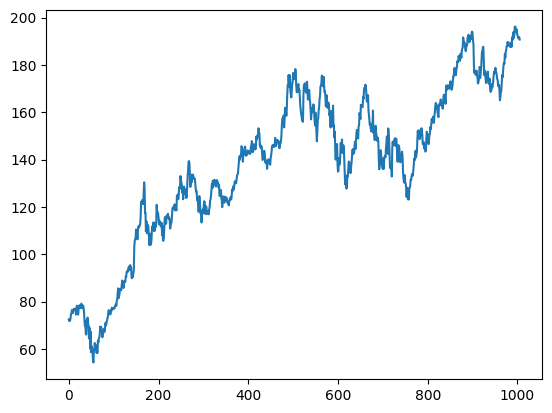

In [168]:
plt.plot(df)

In [169]:
# applying MinMax Scalar
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(df))
print(scaler.data_max_)
df = scaler.transform(df)
df = torch.tensor(df)

# brought every value in between 0 and 1

MinMaxScaler()
[196.25657654]


In [170]:
print(f"{len(df)} , {df.max()} , {df.min()} , {df.dtype}")
print(type(df))

1006 , 0.9999999999999999 , 0.0 , torch.float64
<class 'torch.Tensor'>


In [171]:
def create_dataset(data:Tensor,window_size:30) -> tuple[Tensor,Tensor]:
    """
        input :- data , window_size -> sequence Length
        output :- x_tensor (num_samples,seq_len,1)
                ,y_tensor (num_samples,1)
    
    """
    if len(data.shape) == 1:
        data = data.unsqueeze(1)
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        
        feature = data[i:i+window_size]
        target = data[i+window_size]
        
#         print(feature.shape , target.shape)
        
        x.append(feature)
        y.append(target)
        
# Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting 
# the list to a single numpy.ndarray with numpy.array() before converting to a tenso
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.tensor(y)
    
    x_tensor = torch.stack(x)
    y_tensor = torch.stack(y)

    return x_tensor , y_tensor

In [172]:
x_train , y_train = create_dataset(df,15)
x_train = x_train.float()
y_train = y_train.float()

In [173]:
print(x_train.shape,y_train.shape)
print(x_train.dtype)

torch.Size([991, 15, 1]) torch.Size([991, 1])
torch.float32


In [202]:
class StockPredictor(nn.Module):
    
    # assuming batch_size will be first
    def __init__(self,input_size,hidden_size,bias = True):
        
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers # will use in later implementataion
        
        self.lstm = LSTM(input_size,hidden_size,bias)
                
        # Decoder fully connected layer
        self.fc = nn.Linear(hidden_size,1)
        
    def forward(self, x:Tensor , initial_state : tuple[Tensor,Tensor]):
        
#         print(x.shape,len(initial_state))
        out , (ht,ct) = self.lstm(x,initial_state)
        
        # out has every layers final output
#         print(out.shape)
#         print(out[:,-1,:].shape)
        
        prediction = self.fc(out[:,-1,:])
        
        
        return prediction

In [184]:
# Hyperparams
input_size = 1 # feature is one and sequence is 15(days) here
hidden_size = 64
num_layers = 2
epochs = 100
batch_size = 32

In [203]:
model = StockPredictor(input_size=input_size,
             hidden_size=hidden_size)

In [204]:
lossi = []

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

for epoch in range(epochs):
    
    # high,(shape) and low is 0
    idx = torch.randint(x_train.shape[0],(batch_size,))
    
    x_batch = x_train[idx] 
    y_batch = y_train[idx]
    
#     print(x_batch.shape,y_batch.shape) # batch_size,seq_len,1 -> batch_size,1
    
    h_not = torch.zeros(batch_size,hidden_size)
    c_not = torch.zeros(batch_size,hidden_size)
    
    pred = model(x_batch,(h_not,c_not))
#     print(pred.shape)
    
    loss = loss_fn(pred,y_batch)
    lossi.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

    break

torch.Size([32, 15, 1]) torch.Size([32, 1])
torch.Size([32, 15, 64])
torch.Size([32, 64])
torch.Size([32, 1])
